In [84]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

import os
import pickle

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils_qiskit import find_pauli_indices
from utils import hamiltonian_to_matrix
from algo.utils_qiskit import process_hamiltonian_Zs
from algo.utils_qiskit import optimal_interp_points
from check_utils import interp_matrix

cite: Exploring Entanglement and Optimization within the Hamiltonian Variational
Ansatz

## Transverse-field Ising model

The TFIM is a paradigmatic model for studies of quantum magnetism. The Hamiltonian for the 1 D chain is
given by

$$
H_{\mathrm{TFIM}}=-\sum_{i=1}^N\left[\sigma_i^z \sigma_{i+1}^z+g \sigma_i^x\right]=H_{z z}+g H_x,
$$

with $H_{z z}=-\sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z$ and $H_x=-\sum_{i=1}^N \sigma_i^x$, where we assume that $g>0$ and use periodic boundary conditions $\sigma_{N+1}^z \equiv \sigma_1^z$. Here, $\sigma_i^\alpha$ corresponds to a Pauli matrix $\alpha=x, y, z$ acting on a site $i$, where the Pauli matrices are defined as follows:

$$
\sigma_x \equiv\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_y \equiv\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_z \equiv\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right) .
$$


In [85]:
num_q = 4 # N # IMPORTANT 
"""Circuit construction"""
layer = 1  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 2  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_HVA_TIFM(weights):
    circ = QuantumCircuit(num_q)

    for j in range(num_q):
        circ.h(j) 

    for i in range(layer):
        ## Odd layers
        for j in range(num_q):
            circ.rzz(weights[2 * i], j , (j + 1) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(num_q):
            circ.rx(weights[2 * i + 1], j)  ## YY gates in odd sum
            # weights  [1]


    return circ 

qc = circuit_HVA_TIFM(weights)
# print(qc)
qc.draw("mpl")
fig = qc.draw("mpl")

for text in fig.texts:
    text.set_fontsize(16)  # 设置字体大小为16，调整为你需要的大小
fig.show()

C:\Users\laizh\AppData\Local\Temp\ipykernel_5368\406851664.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [86]:

# Draw the quantum circuit and save it as an image
fig = qc.draw("mpl")  # 'mpl' will return a Matplotlib figure
fig.savefig("quantum_circuit_tifm_HVA.pdf", dpi=600)  # Save the figure as a PNG image
plt.close(fig)  # Close the figure to release memory


In [87]:

# Assuming the circuit is created and the latex code is generated from the circuit as shown below:

latex = qc.draw(output="latex_source")

# Save the latex source to a .tex file
with open("latex_tifm_HVA.tex", "w") as f:
    f.write(latex)



cite: Exploring Entanglement and Optimization within the Hamiltonian Variational
Ansatz

## $X X Z$ model

Another prototypical model for studying quantum magnetism is the XXZ model. For the 1D XXZ model, the Hamiltonian is given by

$$
\begin{aligned}
H_{\mathrm{XXZ}} & =\sum_{i=1}^N\left[\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y+\Delta \sigma_i^z \sigma_{i+1}^z\right] \\
& =H_{x x}+H_{y y}+\Delta H_{z z},
\end{aligned}
$$

with $H_{x x}=\sum_{i=1}^N \sigma_i^x \sigma_{i+1}^x, H_{y y}=\sum_{i=1}^N \sigma_i^y \sigma_{i+1}^y$ and $H_{z z}=$ $\sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z$. Again, we assume periodic boundary conditions. The parameter $\Delta$ controls the spin anisotropy in the model. For $\Delta=1$, this model has an $S U(2)$ symmetry and is equivalent to the Heisenberg chain. For $\Delta \neq 1$, this symmetry gets reduced to a $U(1) \times \mathbb{Z}_2$ symmetry. For $1<|\Delta|$, the system is in the XY quasi-long-range ordered state and becomes gapless in the thermodynamic limit. At $|\Delta|=1$, there is a phase transition to the Néel ordered state. This model can be solved exactly using the Bethe ansatz for $N \rightarrow \infty[24]$.


In this work, we consider the problem of approximating the ground state at the critical points $g=1$ and $\Delta=1$ for the TFIM and the XXZ model, respectively, since their particular entanglement scaling properties makes them harder to approximate using classical methods [25], such as the density-matrix renormalization group (DMRG).

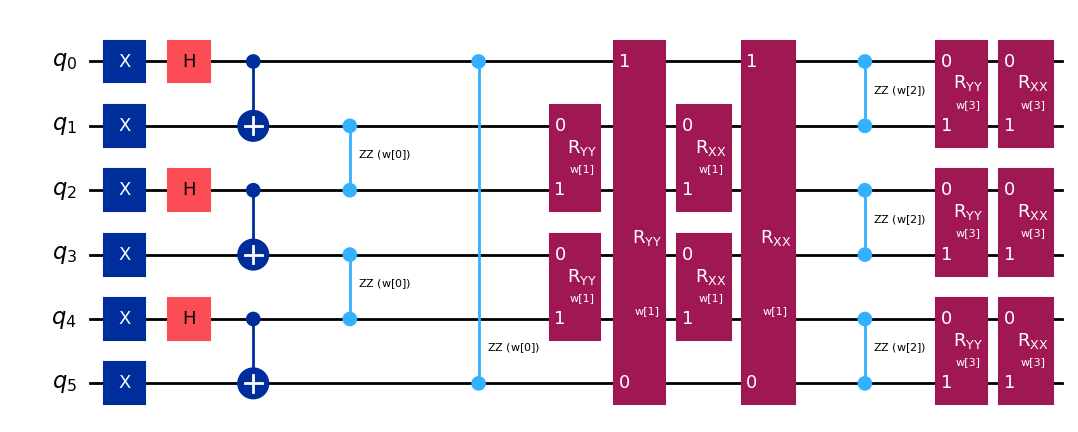

In [88]:
num_q = 6 # N # IMPORTANT 

"""Circuit construction"""
layer = 1  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


In [89]:

# Draw the quantum circuit and save it as an image
fig = qc.draw("mpl")  # 'mpl' will return a Matplotlib figure
fig.savefig("quantum_circuit_XXZ_HVA.pdf", dpi=600)  # Save the figure as a PNG image
plt.close(fig)  # Close the figure to release memory


In [90]:

# Assuming the circuit is created and the latex code is generated from the circuit as shown below:

latex = qc.draw(output="latex_source")

# Save the latex source to a .tex file
with open("latex_XXZ_HVA.tex", "w") as f:
    f.write(latex)

